In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from scipy import spatial

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


from collections import Counter

import dateparser
from time import time
from tqdm import tqdm

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string

from spellchecker import SpellChecker

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim import models, corpora

/Users/nmm/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Initialisation

## Load the data
First, let's load the data into a DataFrame, remove duplicates if there are any and drop rows with articles not recognized as string.

In [ ]:
%%time 
# check how long does it take to run the cell

DATA_PATH = "../Data/"

articles = pd.DataFrame()
# read the csvs file by file
for f in listdir(DATA_PATH):
    curr_df = pd.read_csv(DATA_PATH+f
                          , usecols = ['Article Title', 'Journal', 'Date', 'Url', 'Text']
                          , parse_dates=['Date']
                          , date_parser=dateparser.parse
                         )
    # add the word used to retrieve the article
    curr_df['word'] = f.split('.')[0].split('_')[1]
    articles = articles.append(curr_df)
    print(f, ' : ', len(curr_df)
          , ' | # NaNs : ', np.count_nonzero(curr_df.isnull().values.ravel()))

In [24]:
articles = pd.read_csv("./Data/all_articles.csv")

articles.sample(3)

,Unnamed: 0,Unnamed: 0.1,Article Title,Journal,Date,Url,Text,Unnamed: 0.1.1
18796,7118,118,LA L IBERTé SUISSE Election sans surpris...,La Liberté,5 mars 1990,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,LA L IBERTé SUISSE Election sans surprise du ...,18.0
12267,589,589,•BRUXELLES (ATS/AFP). - Les écologistes ...,Le Nouvelliste,30 avril 1983,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,•BRUXELLES ( ATS / AFP ) . - Les écologistes...,9.0
17669,5991,991,Les comptes 1987 des CFF approuves,Le Nouvelliste,22 juin 1988,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,Les comptes 1987 des CFF approuves BERNE ( A...,11.0


In [25]:
# check that all articles are different 
if not articles.Url.is_unique:
    print("Removing duplicates")
    articles.drop_duplicates(subset="Url"
                             , keep='first'
                             , inplace=True
                             , ignore_index=False
                            )
else:
    print("No duplicates in the DF.")

No duplicates in the DF.


In [26]:
string_mask = [type(text)==str for text in articles["Text"]]
print("There are {0} articles not recognized as strings."\
      .format(len(string_mask)-np.sum(string_mask)))
# remove articles that aren't string
articles = articles[string_mask]

There are 21 articles not recognized as strings.


In [27]:
articles.reset_index(inplace=True)
articles.sample(3)

,index,Unnamed: 0,Unnamed: 0.1,Article Title,Journal,Date,Url,Text,Unnamed: 0.1.1
18308,18327,6649,649,Dramatique politique,Construire,16 septembre 2003,https://www.e-newspaperarchives.ch/?a=d&d=MIG2...,Dramatique politique Un brillant téléfilm re...,9.0
13978,13996,2318,318,Des partis vaudois contre une annonce Le...,Le Nouvelliste,30 mai 1998,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,Des partis vaudois contre une annonce Le comi...,18.0
17086,17105,5427,427,Pierre de Chastonay,Le Nouvelliste,17 janvier 1983,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,Pierre de Chastonay ( x . j . ) . - L année ...,7.0


In [38]:
articles["Date"] = [dateparser.parse(d) for d in articles["Date"]]

## Data concierge

Now let's do some basic textual data cleaning by removing:
- stopwords from nltk's french list, augmented manually
- punctuation
- numerical values
- isolated letters

To do so, we need to tokenize the textual strings first.

In [28]:
STOP_FR = stopwords.words("french")
STOP_FR += ["comme", "tout", "aussi", "sans", "si", "selon"]
STOP_FR += ["de", "du", "des"] # added bc of tfidf on epochs

PUNCTUATION = [punc for punc in string.punctuation]
PUNCTUATION += ["›", "__", "’", "‘", "...", "„", "¦"]

In [29]:
def tokenize_list_articles(list_articles):
    """ tokenize iterable object and remove some pre-defined values """
    tokenized_articles = [word_tokenize(article) for article in list_articles]
    tokenized_articles = [[token.lower() for token in article 
                           if not (token.lower() in STOP_FR+PUNCTUATION
                           or token.isnumeric()
                           or len(token) < 2)
                          ]
                         for article in tokenized_articles]
    return tokenized_articles

In [30]:
%%time 
texts_articles = list(articles["Text"].values)
tokenized_articles = tokenize_list_articles(texts_articles)
# add a column in the DF:
articles["tokens"] = tokenized_articles

CPU times: user 1min 20s, sys: 468 ms, total: 1min 20s
Wall time: 1min 20s


We can then quickly check the proportion of tokens collected that exist in the french vocabulary thanks to the `spellchecker` package.

In [31]:
# create a 1D list containing all the tokes
all_tokens = [token 
              for article in tokenized_articles
              for token in article
             ]
print("Number of tokens in the dataset: {0:.3g}.".format(len(all_tokens)))

Number of tokens in the dataset: 5.49e+06.


In [32]:
french_checker = SpellChecker(language='fr')  # use the french Dictionary

misspelled_tokens = french_checker.unknown(all_tokens)
print("{0:.3g}% of the tokens are considered misspelled.".format(100*len(misspelled_tokens)/len(all_tokens)))

3.75% of the tokens are considered misspelled.


We can get an example of such misspelled words in a random article:

In [33]:
rand_index = np.random.randint(0, len(tokenized_articles))

rand_tokens = tokenized_articles[rand_index]

misspelled_rand = french_checker.unknown(rand_tokens)

print("In article {0}; {1} out of {2} words are considered incorrect. Those are: {3}"\
      .format(rand_index, len(misspelled_rand), len(rand_tokens), misspelled_rand))

In article 7642; 17 out of 129 words are considered incorrect. Those are: {'loutil', 'unesuissesansarmée', 'est-à-dire', 'mésolitique', 'dordre', 'simaginer', 'lorigine', 'larmée', 'lère', 'partenariale', 'linitiative', 'ouià', 'valaisan', 'pev', 'lavenir', 'dardents', 'lexcès'}


# Embed the words in a word-space using Word2Vec

## Naive approach
To familiarize with the techniques and get a first glimpse on the possible outcomes, let's perform the word2vec embedding on the whole dataset.
Note that, as defined below, the model is not deterministic, meaning that running it twice won't provide the same results.

In [13]:
%%time
model = Word2Vec(sentences=tokenized_articles
                       , vector_size=100
                       , window=5
                       , min_count=1
                       , workers=4
                       , sg=1 #skipgram
                       , negative=5 #use of negative sampling
                      )

CPU times: user 3min 22s, sys: 979 ms, total: 3min 23s
Wall time: 54.5 s


Now that the model is built, we can check what words are the closest to "écologie" in this wordspace. 

In [14]:
model.wv.most_similar('écologie', topn=20)

[('ecologie', 0.7696751356124878),
 ('économie', 0.7335042953491211),
 ('lécologie', 0.70684814453125),
 ('spiritualité', 0.687218964099884),
 ('economie', 0.6839091777801514),
 ('conjugue', 0.6833220720291138),
 ('logie', 0.6719521880149841),
 ('ergonomie', 0.6713288426399231),
 ('larchitecture', 0.6695515513420105),
 ('féminisme', 0.6661983728408813),
 ('authenticité', 0.6622793674468994),
 ('rimer', 0.6613501310348511),
 ('réconcilier', 0.660486102104187),
 ('architecture', 0.653905987739563),
 ('concilier', 0.6523356437683105),
 ('alpestre', 0.6502612233161926),
 ('associée', 0.6469996571540833),
 ('psychologie', 0.6434325575828552),
 ('equilibre', 0.6373260617256165),
 ("l'écologie", 0.6352928280830383)]

In [15]:
# explore through different terms to get some insights and check that it makes sense
model.wv.most_similar('noé', topn=20) # :'(

[('abordage', 0.9364420175552368),
 ('blable', 0.9347743391990662),
 ('dispensera', 0.9326705932617188),
 ('lorganisa', 0.93052077293396),
 ('nnnvpau', 0.9292441010475159),
 ('si—tuation', 0.929237425327301),
 ('vaques', 0.9291587471961975),
 ('palombi', 0.9291380643844604),
 ('rapperswil', 0.9291031956672668),
 ('fié', 0.9287330508232117),
 ('diehl', 0.9287188053131104),
 ('respecterait', 0.9287023544311523),
 ('dorsonnens', 0.9285817742347717),
 ('shellswitzerland', 0.9285756945610046),
 ('septantecinq', 0.9284054040908813),
 ('44-140', 0.928334653377533),
 ('jumelée', 0.9283276796340942),
 ('lintelligentsia', 0.9283219575881958),
 ('européenrte', 0.9280431270599365),
 ('indiscriminée', 0.9280322790145874)]

It can be verified that in these lists of words, the first value is a close word in the wordspace and the second value is the cosine similarity between those two terms. The following code allows also to play with the words to see how "close" or "far" two different words are in the built space.

In [16]:
def cosine_sim(word_vec1, word_vec2):
    """ Compute the cosine similarity between two vectors in the wordspace """
    # if the string is provided, convert into vector thanks to the model
    if type(word_vec1)==str:
        word_vec1 = model.wv[word_vec1]
    if type(word_vec2)==str:
        word_vec2 = model.wv[word_vec2]
        
    return 1 - spatial.distance.cosine(word_vec1, word_vec2)

In [17]:
vector_écologie = model.wv['écologie']  # get numpy vector of a word
vector_leitmotiv = model.wv['leitmotiv']
print("cosine_dist(écologie, leitmotiv) = {}".format(cosine_sim(vector_écologie, vector_leitmotiv)))

cosine_dist(écologie, leitmotiv) = 0.5998222231864929


## Add minimum count

Still naive, but a bit less this time, let's build a model considering only words appearing a minimum of $N$ times.

In [18]:
%%time
N_min = 5

model_min5 = Word2Vec(sentences=tokenized_articles
                 , vector_size=100
                 , window=5
                 , min_count=N_min #minimum number of occurences of a word
                 , workers=4
                 , sg=1 #skipgram
                 , negative=5 #use of negative sampling
                )

CPU times: user 2min 30s, sys: 1.46 s, total: 2min 31s
Wall time: 39.3 s


In [19]:
model_min5.wv.most_similar('écologie', topn=20)

[('ecologie', 0.6928344368934631),
 ('lécologie', 0.6797698736190796),
 ('économie', 0.6465134620666504),
 ('authenticité', 0.6454559564590454),
 ('larchitecture', 0.6450992226600647),
 ('notions', 0.6346209049224854),
 ('spiritualité', 0.6281835436820984),
 ('réconcilier', 0.627711296081543),
 ('rimer', 0.6209587454795837),
 ('logie', 0.6168228387832642),
 ('conjugue', 0.6151474118232727),
 ('economie', 0.6145298480987549),
 ('ergonomie', 0.6066305637359619),
 ('architecture', 0.6031275391578674),
 ('psychologie', 0.5982493758201599),
 ('science', 0.5967456698417664),
 ('décologie', 0.5949020385742188),
 ('anthropologie', 0.5926445722579956),
 ('naît', 0.5914017558097839),
 ('equilibre', 0.5904577970504761)]

In [20]:
model.wv.most_similar('suisse', topn=20)

[('romande', 0.7775385975837708),
 ('helvétique', 0.7334420680999756),
 ('alémanique', 0.7080507874488831),
 ('horlogère', 0.6978155374526978),
 ('ofel', 0.6942216157913208),
 ('recom', 0.6838376522064209),
 ('consommatrices', 0.6835519075393677),
 ('suisses', 0.6764481663703918),
 ('sarasin', 0.6731352210044861),
 ('suissi', 0.6720443367958069),
 ('radiodiffusion', 0.6685492992401123),
 ("l'europe", 0.6673134565353394),
 ('sgu', 0.6649631857872009),
 ('observateur', 0.6646692156791687),
 ('pay', 0.6643516421318054),
 ('romandie', 0.6630659103393555),
 ('frc', 0.6627447009086609),
 ('dations', 0.6623170971870422),
 ('fre', 0.6622632145881653),
 ('greina', 0.6602676510810852)]

## Build different models for different epochs 

To check if we can see some differences between the different time periods, let's split the data in 3 parts: prior to 1990, between 1990 and 2000 and after 2000.

In [39]:
mask_rise = [(date.year < 1990 and date.year > 1970) for date in pd.to_datetime(articles.Date)]
mask_peak = [(date.year > 1990 and date.year < 2000) for date in pd.to_datetime(articles.Date)]
mask_stable = [(date.year > 2000) for date in pd.to_datetime(articles.Date)]

df_rise = articles[mask_rise]
df_peak = articles[mask_peak]
df_stable = articles[mask_stable]

print(len(df_rise), len(df_peak), len(df_stable))

7211 7104 6804


In [259]:
%%time 

model_rise = Word2Vec(sentences=df_rise.tokens.values
                 , vector_size=100 # test algo
                 , window=5 # test between 5 and 10
                 , min_count=10 # can be higher
                 , workers=4
                 , sg=1 #skipgram
                 , negative=5 #use of negative sampling -> 5-20 for small, 2-5 for large
                 , seed=42
                 , compute_loss=True 
                )

model_peak = Word2Vec(sentences=df_peak.tokens.values
                 , vector_size=100
                 , window=5
                 , min_count=10
                 , workers=4
                 , sg=1 #skipgram
                 , negative=5 #use of negative sampling
                 , seed=42
                )

model_stable = Word2Vec(sentences=df_stable.tokens.values
                 , vector_size=100
                 , window=5
                 , min_count=10
                 , workers=4
                 , sg=1 #skipgram
                 , negative=5 #use of negative sampling
                 , seed=42
                )

CPU times: user 2min 33s, sys: 850 ms, total: 2min 34s
Wall time: 41.6 s


In [41]:
model_rise.wv.most_similar('écologie', topn=20)

[('ecologie', 0.7080118060112),
 ('economie', 0.6976367235183716),
 ('sociologie', 0.6724958419799805),
 ('féminisme', 0.6533524394035339),
 ('psychologie', 0.6427956223487854),
 ('lécologie', 0.6400192379951477),
 ('solidarité', 0.6322773694992065),
 ('science', 0.6272888779640198),
 ('mie', 0.6210886240005493),
 ('éco', 0.6168339252471924),
 ('sexuelle', 0.6154652237892151),
 ('associé', 0.6139942407608032),
 ('réconcilier', 0.6137310266494751),
 ('piliers', 0.613154411315918),
 ('décologie', 0.6120284199714661),
 ('autel', 0.608607292175293),
 ("l'inflation", 0.6084698438644409),
 ('notions', 0.6061925888061523),
 ('enseigne', 0.605958104133606),
 ('léthique', 0.6043466329574585)]

In [42]:
model_peak.wv.most_similar('écologie', topn=20)

[('lécologie', 0.7209407687187195),
 ('économie', 0.6964447498321533),
 ('authenticité', 0.6706597805023193),
 ('rimer', 0.6629214882850647),
 ('ecologie', 0.6619811654090881),
 ('modernité', 0.6614567637443542),
 ('concilier', 0.6575073599815369),
 ('conjuguer', 0.6547108888626099),
 ('equilibre', 0.6449065804481506),
 ('economie', 0.6420674324035645),
 ('tendues', 0.6352580189704895),
 ('réconcilier', 0.6341352462768555),
 ('réconciliation', 0.6339784264564514),
 ('lien', 0.6297266483306885),
 ('concilie', 0.623083770275116),
 ('adéquation', 0.6225046515464783),
 ('didées', 0.6147373914718628),
 ("l'écologie", 0.611269474029541),
 ('et/ou', 0.6091107130050659),
 ('symbiose', 0.6082876920700073)]

In [43]:
model_stable.wv.most_similar('écologie', topn=20)

[('ecologie', 0.7002133131027222),
 ('décologie', 0.6764310002326965),
 ('spiritualité', 0.6735173463821411),
 ('liens', 0.6674690842628479),
 ('réconcilier', 0.6666184067726135),
 ('lécologie', 0.6587350368499756),
 ('science', 0.647040069103241),
 ('architecture', 0.6430125832557678),
 ('simplicité', 0.6405431032180786),
 ('partage', 0.6402467489242554),
 ('ergonomie', 0.6383662223815918),
 ('psychologie', 0.6343562602996826),
 ('médecine', 0.6326971054077148),
 ('alliant', 0.6302816867828369),
 ('incompatibles', 0.629975438117981),
 ('ciblée', 0.6255782842636108),
 ('respectueuse', 0.6252753138542175),
 ('logie', 0.6252638697624207),
 ('technologie', 0.6252434849739075),
 ('mariage', 0.6250934600830078)]

In [44]:
vector_écologie_rise = model_rise.wv['écologie']
vector_écologie_peak = model_peak.wv['écologie']
vector_écologie_stable = model_stable.wv['écologie']

vector_science_rise = model_rise.wv['science']
vector_politique_rise = model_rise.wv['politique']

vector_science_peak = model_peak.wv['science']
vector_politique_peak = model_peak.wv['politique']

vector_science_stable = model_stable.wv['science']
vector_politique_stable = model_stable.wv['politique']

print("1970-1980: cosinedist(écologie, science)= {0:.3f} | cosinedist(écologie, politique)= {1:.3f}"\
     .format(cosine_sim(vector_écologie_rise, vector_science_rise)
             , cosine_sim(vector_écologie_rise, vector_politique_rise)
            )
     )

print("1990-2000: cosinedist(écologie, science)= {0:.3f} | cosinedist(écologie, politique)= {1:.3f}"\
     .format(cosine_sim(vector_écologie_peak, vector_science_peak)
             , cosine_sim(vector_écologie_peak, vector_politique_peak)
            )
     )

print("2000-...: cosinedist(écologie, science)= {0:.3f} | cosinedist(écologie, politique)= {1:.3f}"\
     .format(cosine_sim(vector_écologie_stable, vector_science_stable)
             , cosine_sim(vector_écologie_stable, vector_politique_stable)
            )
     )

1970-1980: cosinedist(écologie, science)= 0.627 | cosinedist(écologie, politique)= 0.359
1990-2000: cosinedist(écologie, science)= 0.592 | cosinedist(écologie, politique)= 0.322
2000-...: cosinedist(écologie, science)= 0.647 | cosinedist(écologie, politique)= 0.299


# LDA

Find topics on the whole dataset.

In [ ]:
dictionary_LDA = corpora.Dictionary(tokenized_articles)
dictionary_LDA.filter_extremes(no_below=N_min)

corpus = [dictionary_LDA.doc2bow(article) for article in tokenized_articles]

In [ ]:
num_topics = 6
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

In [ ]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

# TF-IDF

In [ ]:
vectorizer = TfidfVectorizer()
X_TFIDF = vectorizer.fit_transform(articles["Text"].values)

X_TFIDF.shape #len(articles = 21760)

In [ ]:
print(X_TFIDF.argmax(axis=0))
print(X_TFIDF.argmax(axis=1))

In [ ]:
vectorizer.get_feature_names()[38049]

In [ ]:
articles["Text"].values[0]

In [ ]:
vectorizer.get_feature_names()[0]

In [ ]:
articles["Text"].values[20452]

In [ ]:
text_rise = ' '.join(df_rise.Text.values)
text_peak = ' '.join(df_peak.Text.values)
text_stable = ' '.join(df_stable.Text.values)

docs = [text_rise, text_peak, text_stable]

In [ ]:
vectorizer_epochs = TfidfVectorizer()
X_TFIDF_epochs = vectorizer_epochs.fit_transform(docs)

X_TFIDF_epochs.shape #len(articles = 21760)

In [ ]:
print(X_TFIDF_epochs.argmax(axis=1))

In [ ]:
vectorizer_epochs.get_feature_names()[51752]

# PCA Trial

In [ ]:
X_TFIDF

# DRAFT

In [ ]:
STOOOP_RUNNIG

In [ ]:
model_pre_80.wv.most_similar('écologie', topn=20)

In [ ]:
model_post_92.wv.most_similar('écologie', topn=20)

### Try to align models from different epochs

In [48]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # patch by Richard So [https://twitter.com/richardjeanso) (thanks!) to update this code for new version of gensim
    # base_embed.init_sims(replace=True)
    # other_embed.init_sims(replace=True)

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

In [260]:
model_w2v_new = models.Word2Vec(sg = 1, vector_size=100)
model_w2v_new.build_vocab(set(model_rise.wv.index_to_key))

model_w2v_new.wv.vectors = model_rise.wv.vectors

In [261]:
model_w2v_new2 = models.Word2Vec(sg = 1, vector_size=100)
model_w2v_new2.build_vocab(set(model_rise.wv.index_to_key))

model_w2v_new2.wv.vectors = model_rise.wv.vectors

In [269]:
model_w2v_new.reset_from(model_rise)
model_w2v_new2.reset_from(model_rise)

In [270]:
model_peak_modified = smart_procrustes_align_gensim(model_w2v_new
                                                    , model_peak
                                                   )

14494 14494
14494 14494


In [271]:
model_stable_modified = smart_procrustes_align_gensim(model_w2v_new2
                                                    , model_stable
                                                   )

13371 13371
13371 13371


In [232]:
len(model_peak.wv.index_to_key)

12455

In [181]:
m1, m2 = intersection_align_gensim(model_rise, model_peak)
_, m3 = intersection_align_gensim(m2, model_stable)

12455 12455
12455 12455


In [225]:
m1.wv['écologie']-m2.wv["écologie"]

array([-0.5163502 , -0.20278578,  0.19056162,  0.6479537 ,  0.03386853,
       -0.20186004,  0.15324712, -0.19052231,  0.24810928, -0.33271402,
        0.5946561 ,  0.51298964,  0.7070013 ,  0.45237413, -0.29032752,
        0.71180236,  0.10859609, -0.26096544,  0.45730993,  1.0379279 ,
       -0.6854936 , -0.3330346 ,  0.4741881 ,  0.6447381 , -0.39879417,
        0.25527215,  0.15140137,  0.12249509, -0.15788388, -0.24500355,
       -0.2676247 , -0.64297116, -0.24673234, -0.35939327,  0.17290342,
       -0.29067785,  0.3192569 , -0.8817328 , -0.15889236, -0.07840319,
        0.7892148 , -0.36731362,  1.1543174 , -0.6661559 ,  0.00257671,
        0.1357656 , -0.05291441, -0.37724417,  0.35383502,  0.0243727 ,
        0.00748748, -0.44473588,  0.4671502 , -0.18420093, -0.10043317,
       -0.6654015 ,  0.21530819,  0.7169709 , -0.20786145, -0.34442294,
        0.5514822 ,  0.5235392 ,  0.48565835,  0.0121882 ,  0.3676341 ,
       -0.10230379,  0.5254159 , -0.11282015, -0.33520907, -0.30

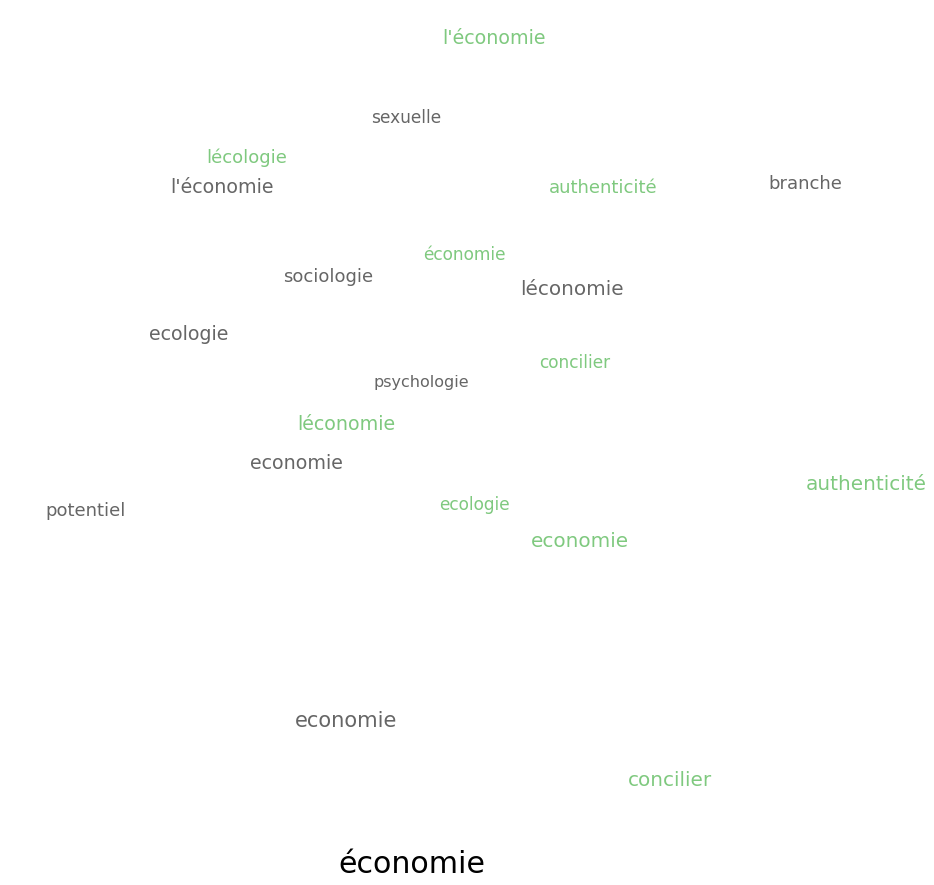

In [237]:
plt.figure(figsize=(15,15))
for word1 in ['écologie', 'économie']:
        time_sims, lookups, nearests, sims = get_time_sims({1970: model_rise
                                                            , 1990:model_peak_modified}
                                                           , word1)

        words = list(lookups.keys())
        values = [ lookups[word] for word in words ]
        fitted = fit_tsne(values)
        if not len(fitted):
            print("Couldn't model word", word1)
            continue

        # draw the words onto the graph
        cmap = plt.cm.get_cmap("Accent", len(time_sims))
        annotations = plot_words(word1, words, fitted, cmap, sims)

        if annotations:
            plot_annotations(annotations)

        plt.savefig("%s_annotated" % word1)
        #for year, sim in time_sims.items():
            #print(year, sim)

In [132]:
import collections
from sklearn.manifold import TSNE 
import matplotlib

In [210]:
def plot_words(word1, words, fitted, cmap, sims):
    # TODO: remove this and just set the plot axes directly
    plt.scatter(fitted[:,0], fitted[:,1], alpha=0)
    plt.suptitle("%s" % word1, fontsize=30, y=0.1)
    plt.axis('off')

    annotations = []
    isArray = type(word1) == list
    for i in range(len(words)):
        pt = fitted[i]

        ww,decade = [w.strip() for w in words[i].split("|")]
        color = cmap(int(int(decade)==1970))
        word = ww
        sizing = sims[words[i]] * 30

        # word1 is the word we are plotting against
        if ww == word1 or (isArray and ww in word1):
            annotations.append((ww, decade, pt))
            word = word1+"("+decade+")"
            color = 'black'
            sizing = 15


        plt.text(pt[0], pt[1], word, color=color, size=int(sizing))

    return annotations

In [139]:
def plot_annotations(annotations):
    # draw the movement between the word through the decades as a series of
    # annotations on the graph
    annotations.sort(key=lambda w: w[1], reverse=True)
    prev = annotations[0][-1]
    for ww, decade, ann in annotations[1:]:
        plt.annotate('', xy=prev, xytext=ann,
            arrowprops=dict(facecolor='blue', shrink=0.1, alpha=0.3,width=2, headwidth=15))
        prev = ann

In [128]:
def fit_tsne(values):
    if not values:
        return

    mat = np.array(values)
    model = TSNE(n_components=2, random_state=0, learning_rate=150, init='pca')
    fitted = model.fit_transform(mat)

    return fitted

In [208]:
def get_time_sims(models, word1):
    time_sims = collections.OrderedDict()
    lookups = {}
    nearests = {}
    sims = {}
    for year, embed in models.items():
        nearest = []
        nearests["%s|%s" % (word1, year)]= nearest
        time_sims[year] = []

        for word, sim in embed.wv.most_similar(word1, topn=5):
            ww = "%s|%s" % (word, year)
            nearest.append((sim, ww))
            if sim > 0.3:
                time_sims[year].append((sim, ww))
                lookups[ww] = embed.wv[word]
                sims[ww] = sim

    return time_sims, lookups, nearests, sims

écologie
ecologie
economie


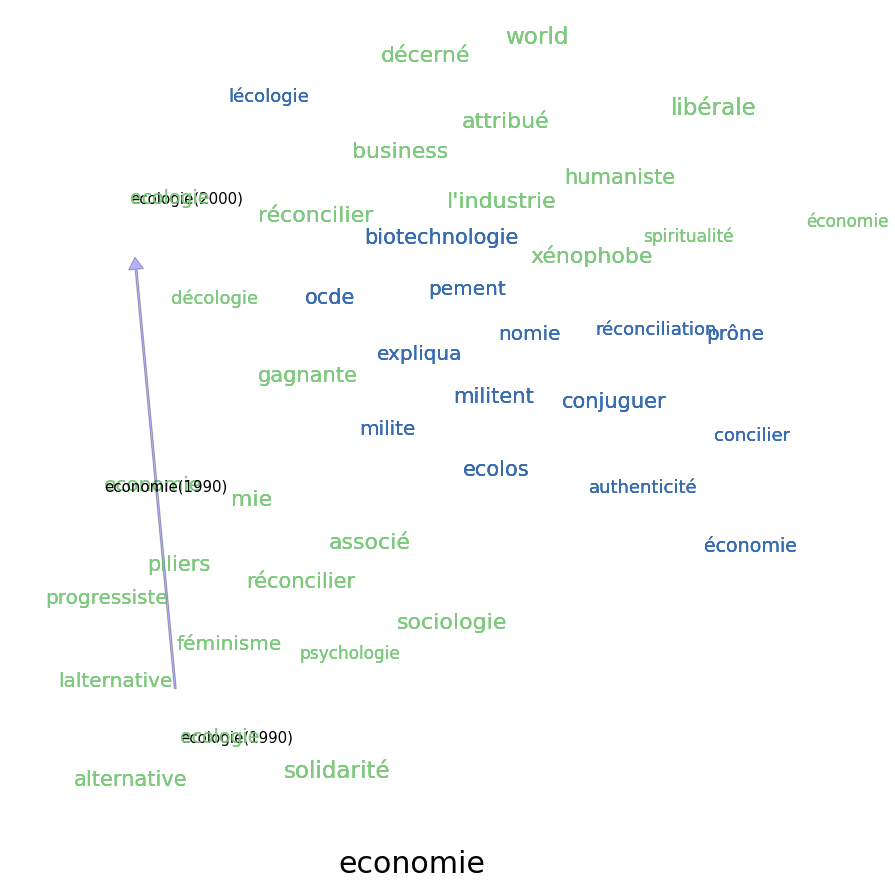

In [275]:
all_lookups = {}
all_sims = {}

WORDS = ['écologie', 'ecologie', 'economie']

wordchain = "_".join(WORDS)
    
for word1 in WORDS:
    print(word1)
    time_sims, lookups, nearests, sims = get_time_sims({1970: model_peak_modified
                                                        , 1990:model_rise
                                                        , 2000:model_stable_modified
                                                       }
                                                       , word1)

    all_lookups.update(lookups)
    all_sims.update(sims)




words = list(all_lookups.keys())
values = [ all_lookups[word] for word in words ]
fitted = fit_tsne(values)

# draw the words onto the graph
cmap = plt.cm.get_cmap("Accent", len(time_sims))


plt.figure(figsize=(15,15))
for word1 in WORDS:
    # TODO: split the annotations up
    annotations = plot_words(word1, words, fitted, cmap, all_sims)
    if annotations:
        plot_annotations(annotations)

    plt.savefig("%s_chain.png" % wordchain)

In [60]:
set_rise = set.union(*map(set,[tokens for tokens in df_rise.tokens]))
set_peak = set.union(*map(set,[tokens for tokens in df_peak.tokens]))
set_stable = set.union(*map(set,[tokens for tokens in df_stable.tokens]))

In [64]:
set_rise.difference(set_peak)

{'tiner',
 'souvenons-nous',
 'super-folie',
 'avérés',
 'administrationrédaction',
 'participerai',
 'suisse-suède',
 'saint-paul-hors-les-murs',
 'ouest-al-lemandes',
 'jea',
 'stasius',
 'irrémédia',
 'weltz',
 'contnbuons',
 'particulairét',
 'aiseraugst',
 "l'imbëcilitë",
 'scpri',
 'valaivont',
 '—l',
 'rosène',
 'zootechnique',
 'loisedu',
 'àvex',
 'dévacua',
 'plajda',
 'cifistes',
 'poisonné',
 'ênergéti',
 'transloc',
 'raom',
 'reus-',
 'enlaidissement',
 'obstrué',
 'élevei',
 'vetage',
 'apprenti-sorcier',
 'filé',
 'généialiser',
 'quelcune',
 'sapanoplie',
 'dianasuissemettrasurpied',
 'négateurs',
 'tellico',
 'boh',
 'vogaâen',
 'joccuperaiune',
 'normes-de',
 'drlre',
 '6-8',
 'dyork',
 'ttce',
 'joun',
 'frondaison',
 'cen-tre-ville',
 'tannaa',
 'lutzelfluh',
 'gangster',
 'pseudodéfenseurs',
 'robmcelnea',
 'longitudinal',
 'policés',
 'planchon',
 'ouloot',
 'dévoiements',
 'ro-bots-second',
 'agen-cosmos-1402',
 "s'écarter",
 'gouverne-en',
 'délaissés',
 'marty

In [45]:
from functools import reduce

# Code originally ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
# https://gist.github.com/tangert/106822a0f56f8308db3f1d77be2c7942
def align_gensim_models(models, words=None):
    """
    Returns the aligned/intersected models from a list of gensim word2vec models.
    Generalized from original two-way intersection as seen above.
    
    Also updated to work with the most recent version of gensim
    Requires reduce from functools
    
    In order to run this, make sure you run 'model.init_sims()' for each model before you input them for alignment.
    
    ##############################################
    ORIGINAL DESCRIPTION
    ##############################################
    
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocabs = [set(m.wv.key_to_index.keys()) for m in models]

    # Find the common vocabulary
    common_vocab = reduce((lambda vocab1,vocab2: vocab1&vocab2), vocabs)
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    
    # This was generalized from:
    # if not vocab_m1-common_vocab and not vocab_m2-common_vocab and not vocab_m3-common_vocab:
    #   return (m1,m2,m3)
    if all(not vocab-common_vocab for vocab in vocabs):
        print("All identical!")
        return models
        
    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    #common_vocab.sort(key=lambda w: sum([m.wv.key_to_index[w] for m in models]),reverse=True)
    
    # Then for each model...
    for m in models:
        
        # Replace old vectors_norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
                
        old_arr = m.wv.get_normed_vectors()
                
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors_norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.wv.index2word = common_vocab
        old_vocab = m.wv.key_to_index
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = Word2Vec.build_vocab(index=new_index, count=old_vocab_obj)
        m.wv.vocab = new_vocab

    return models

In [46]:
align_gensim_models([model_pre_80, model_post_92], words=None)

NameError: name 'model_pre_80' is not defined

In [ ]:
model_pre_80.wv.key_to_index